# Deep Learning - Cryptocurrency Market Analysis with Convolutional Neural Networks

Trading positions in financial markets can be very difficult. There is a steep learning curve for individuals who want to get involved with trading in these markets. Also, there is a high risk of losing your money just as there is in making money. However, if your trading decisions are the well informed then you stand to make a significant amount of money. There are countless numerical and graphical methods of analysing financial markets to better understand what it will probably end up doing; these are predictive analysis techniques. 

Machine learning and deep learning have already been applied to this task of making predictive analysis. However, using image classification through deep learning of the market activity plots themselves is an underdeveloped application in this field. Using deep learning on a financial market activity plot images has great potential to produce valuable predictive results that few, if any, individuals or organizations are taking advantage of as this new technology is developed.

A key part of proceeding with a successful analysis starts with setting up a market viewer with the most expressive price movement representations. Such as choosing, bin width, time scale, image overlap, using candlesticks or simple lines, along with over layed metrics such as moving averages or any other of the dozens of indicators that may be viewed on or along with a activity plot.


For my analysis I take a series of images and train an Convolutional Neural Network to look at one 7-day image and predict if in the next image days price movement will result in an overall average positive, neutral, or negative price movement. Test images are evaluated ad assigning as Gain, Neutral, or Loss by summing the green and red pixels that the candlesticks are made of and computing a ratio for the image. If the ratio is close to 1.0, then the classification is Neutral. Higher ratios will count as Gain, while lower ratios will count as Loss. 


Data Source: https://www.bitstamp.net/market/tradeview

* For information on my data collection, you can look at my image scraper, image_scraper.py, in this project's repo.
* For information on my image processing and preparation, you can look at the Image_Dataset_Prep.ipynb in this project's repo. 

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import drive

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import (
    Activation,
    Dropout,
    Flatten,
    Dense,
)
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import applications

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Mount google drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls "/content/gdrive/My Drive/Colab Notebooks/images"

pred_images  tmp  training  validation


In [4]:
# Image directories
img_dir = "/content/gdrive/My Drive/Colab Notebooks/images"
training_data_dir = "/content/gdrive/My Drive/Colab Notebooks/images/training/classes"
validation_data_dir = "/content/gdrive/My Drive/Colab Notebooks/images/validation/classes"
tmp_checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/images/tmp/checkpoint"
tmp_checkpoint_dir_2 = "/content/gdrive/My Drive/Colab Notebooks/images/tmp/checkpoint_2"

# Class directories
gain_training_data_dir = "/content/gdrive/My Drive/Colab Notebooks/images/training/classes/gain"
neutral_training_data_dir = "/content/gdrive/My Drive/Colab Notebooks/images/training/classes/neutral"
loss_training_data_dir = "/content/gdrive/My Drive/Colab Notebooks/images/training/classes/loss"
gain_validation_data_dir = "/content/gdrive/My Drive/Colab Notebooks/images/validation/classes/gain"
neutral_validation_data_dir = "/content/gdrive/My Drive/Colab Notebooks/images/validation/classes/neutral"
loss_validation_data_dir = "/content/gdrive/My Drive/Colab Notebooks/images/validation/classes/loss"

# Pathnames for examples of classes
gain_img_filepath = "/content/gdrive/My Drive/Colab Notebooks/images/training/classes/gain/image_259.png"
neutral_img_filepath = "/content/gdrive/My Drive/Colab Notebooks/images/training/classes/neutral/image_559.png"
loss_img_filepath =  "/content/gdrive/My Drive/Colab Notebooks/images/training/classes/loss/image_484.png"

# Classes Representation

Below is a set of 3 training data images that belong to each of the three classes: gain, neutral, or loss. i.e. the day following these 7 day images have been classified as a gain day, neutral day, or a loss day.

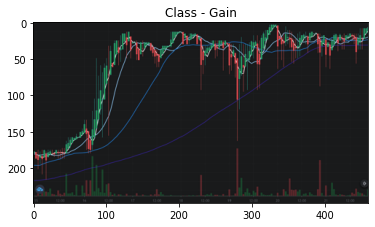

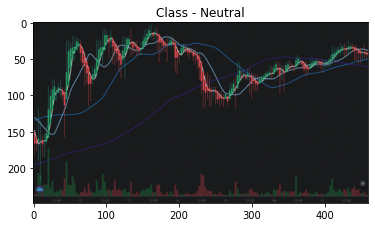

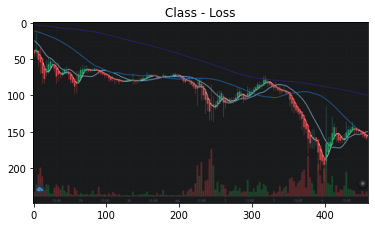

In [5]:
img = mpimg.imread(gain_img_filepath)
imgplot = plt.imshow(img)
plt.title("Class - Gain")
plt.show()

img = mpimg.imread(neutral_img_filepath)
imgplot = plt.imshow(img)
plt.title("Class - Neutral")
plt.show()

img = mpimg.imread(loss_img_filepath)
imgplot = plt.imshow(img)
plt.title("Class - Loss")
plt.show()

The class representation is nearly even thirds of the dataset, with neutral leading the race at 44% of the ground truth data. This should result in higher model performance since the dataset is not too heavily skewed in any direction. After looking at many images in each dataset class, it becomes easier to see visual cues that the next day's price action will do one thing or another.

# Image processing with Keras

In [6]:
image_width, image_height = (460, 240)  # pixels (x, y)
batch_size =  16 # Size of the sample that is used in iteration training
epochs = 20
training_sample_size = 2779
validation_sample_size = 520

In [7]:
# For detecting the format of the data from the environment
if K.image_data_format() == "channels_first":
    input_shape = (3, image_width, image_heigth)
else:
    input_shape = (image_width, image_height, 3)

In [8]:
input_shape

(460, 240, 3)

In [9]:
# Processes images and applys data augmentation
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1. / 255)

In [10]:
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [11]:
# Define the path and parameters of images being loaded in
train_generator = train_datagen.flow_from_directory(
    training_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 2779 images belonging to 3 classes.


In [12]:
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 520 images belonging to 3 classes.


# CNN Model

In [13]:
# Initialize Sequential API
model = Sequential()

# First convolution layer with 32 filters with 3x3 size
model.add(Conv2D(32, (3, 3), activation = "relu", input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2))) 

# Second convolution layer with 64 filters 3x3 filter size
model.add(Conv2D(64, (3, 3),  activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolution layer with 128 filters 3x3 filter size
model.add(Conv2D(128, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth convolution layer with 32 filters with 3x3 size
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.5))

# Flatten the image
model.add(Flatten())

# Output Layer
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(3, activation = "softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 458, 238, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 229, 119, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 227, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 113, 58, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 56, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 26, 64)        7

The number of parameters is acceptable. Though can be reduced if necessary with the use of more convolution and maxpooling layers.

In [15]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"])

In [16]:
checkpoint_filepath = tmp_checkpoint_dir
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
)
callback_list = [model_checkpoint_callback]

In [17]:
cnn_history = model.fit_generator(
    train_generator,
    epochs=50,
    callbacks=callback_list,
    validation_data=validation_generator,
    steps_per_epoch=training_sample_size // batch_size,
    validation_steps=validation_sample_size // batch_size,
)


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


173/173 [==============================] - 26s 127ms/step - loss: 1.0871 - accuracy: 0.3731 - val_loss: 1.0707 - val_accuracy: 0.4785

Epoch 00001: val_accuracy improved from -inf to 0.47852, saving model to /content/gdrive/My Drive/Colab Notebooks/images/tmp/checkpoint
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/images/tmp/checkpoint/assets
Epoch 2/20
173/173 [==============================] - 21s 119ms/step - loss: 1.0798 - accuracy: 0.3744 - val_loss: 1.0562 - val_accuracy: 0.4707

Epoch 00002: val_accuracy did not improve from 0.47852
Epoch 3/20
173/173 [==============================] - 21s 122ms/step - loss: 1.0738 - accuracy: 0.4280 - val_loss: 1.0645 - val_accuracy: 0.4727

Epoch 00003: val_accuracy did not improve from 0.47852
Epoch 4/20
173/173 [==============================] - 21s 122ms/step - loss: 1.0700 - accuracy: 0.4204 - val_loss: 1.0719 - val_accuracy: 0.4824

Epoch 00004: val_accuracy improved from 0.47852 to 0.48242, saving model to 

# CNN Model Evaluation

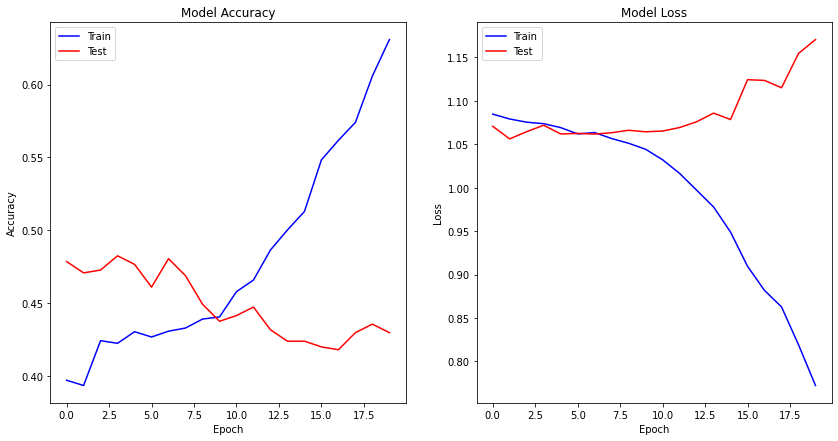

In [18]:
# Plot accuracy and loss to visualize model results

plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.plot(cnn_history.history['accuracy'], color='b')
plt.plot(cnn_history.history['val_accuracy'], color='r')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.subplot(1,2,2)
plt.plot(cnn_history.history['loss'], color='b')
plt.plot(cnn_history.history['val_loss'], color='r')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

plt.show()

The CNN model shows promising performance with the training dataset; though, a max accuracy score of about 63% is not saying much, nor is a minimum training loss of 0.77. Though, the training set works much better with the model than the test / validation set. The score for accuracy and loss continue to get worse after each epoch. This could be due to a combination of overfitting, inadequate network architecture, and hyperparameters out of tune with each other and the model. It is a very complex and painstaking process to debug and optimize a CNN model and it's training process. Let's check out a few more evaluation metrics before moving onto a model that is built on a pre-trained image classification CNN model.

In [19]:
# Save model weights and architecture
model.save("predict_day_market.h5")

In [21]:
# Load saved model
trained_model = load_model("predict_day_market.h5")

## Can train on new data here
# trained_model.fit(new_X_train, new_y_train)
# trained_model.evaluate()

# Trained_model.save("predict_day_market.h5")

In [22]:
# Model summary
trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 458, 238, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 229, 119, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 227, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 113, 58, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 56, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 26, 64)        7

In [24]:
# Use weights from best model with model structure

# Initialize Sequential API
model = Sequential()

# First convolution layer with 32 filters with 3x3 size
model.add(Conv2D(32, (3, 3), activation = "relu", input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2))) 

# Second convolution layer with 64 filters 3x3 filter size
model.add(Conv2D(64, (3, 3),  activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolution layer with 128 filters 3x3 filter size
model.add(Conv2D(128, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth convolution layer with 32 filters with 3x3 size
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.4))

# Flatten the image
model.add(Flatten())

# Output Layer
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(3, activation = "softmax"))

# Add best weights
model.load_weights("predict_day_market.h5")

In [26]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001), metrics=['accuracy'])

This is the models best observer performance so far. Now we can evaluate with metrics such as test loss and test accuracy and compute a confusion matrix and classification report.

> Indented block



In [28]:
# Evaluation scores
scores = model.evaluate(validation_generator, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 1.172140121459961
Test accuracy: 0.428846150636673


In [33]:
# Make Predictions
predictions = model.predict_generator(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
#predicted_classes

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([1, 2, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2,
       0, 1, 2, 0, 2, 2, 2, 0, 1, 1, 1, 2, 0, 2, 2, 0, 2, 0, 2, 1, 2, 1,
       2, 2, 0, 0, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 1, 2, 2, 1,
       2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2,
       2, 2, 0, 0, 2, 0, 1, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 0, 1, 2, 0, 1,
       2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 1, 2, 2, 0, 2, 2, 0, 1,
       2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0,
       0, 1, 1, 0, 0, 2, 1, 2, 1, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0,
       0, 1, 2, 2, 2, 0, 2, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 0, 2, 2, 0, 1,
       0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 1, 0, 2, 1, 1, 0,
       1, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 1, 1, 1, 0, 0, 2, 1, 1, 2, 2,
       2, 0, 0, 1, 1, 0, 2, 0, 0, 2, 2, 1, 2, 1, 2, 2, 0, 2, 0, 2, 2, 2,
       1, 2, 1, 2, 0, 2, 2, 0, 2, 0, 2, 1, 2, 0, 2,

In [34]:
y_true = validation_generator.classes
#y_true

In [35]:
# Confusion matrix
cm = confusion_matrix(y_true, predicted_classes)
cm

# Labels: gain, neutral, loss

array([[ 52,  22,  83],
       [ 41,  23,  53],
       [ 74,  43, 129]])

In [36]:
# Classification report
class_labels = list(validation_generator.class_indices.keys()) 
report = classification_report(y_true, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

        gain       0.31      0.33      0.32       157
        loss       0.26      0.20      0.22       117
     neutral       0.49      0.52      0.50       246

    accuracy                           0.39       520
   macro avg       0.35      0.35      0.35       520
weighted avg       0.38      0.39      0.39       520



From the evaluation metrics, it's easy to see that this model does not perform very well as is. The confusion matrix tell us that the model is having the hardest time predicting losses, then gains, then neutral classes. The most common error was When the model predicted loss but the reality was a gain. Which makes sense; in the trading world these are called bear traps and are end up tricking people to sell when they really should have bought the dip.

# Xception model

Using pretrained models can offer large boosts in performance; that's exactly what this data needs right now. Xception is trained on ImageNet and can be found in Ke

```
# This is formatted as code
```

ras Applications, Available Models.

In [39]:
# Xception CNN classifier
base_model_Xception = applications.Xception(
    weights='imagenet', # use pre-trained weights
    include_top=False # not including fully connected layers
)

# Pooling layer
x = base_model_Xception.output
x = GlobalAveragePooling2D()(x)

# Dropout layer
x = Dropout(0.4)(x)

# Classification layer for output (fully-connected)
predictions = Dense(3, activation='softmax')(x)

# Create full network for training
Xception_model = Model(
    inputs=base_model_Xception.input,
    outputs=predictions
)

Xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [43]:
# Compile Xception model
Xception_model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=.0001, momentum=0.9), metrics=['accuracy'])

In [45]:
# Use Keras ModelCheckpoint to save the best model
checkpoint_filepath_2 = tmp_checkpoint_dir_2
model_checkpoint_callback_2 = ModelCheckpoint(
    filepath = checkpoint_filepath_2,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
 )
callback_list_2 = [model_checkpoint_callback_2]

Xception_history = Xception_model.fit_generator(
    train_generator,
    epochs=epochs,
    callbacks = callback_list_2,
    validation_data=validation_generator,
    steps_per_epoch=training_sample_size // batch_size,
    validation_steps=validation_sample_size // batch_size,
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
173/173 [==============================] - 127s 705ms/step - loss: 1.0992 - accuracy: 0.3703 - val_loss: 1.0778 - val_accuracy: 0.4531

Epoch 00001: val_accuracy improved from -inf to 0.45312, saving model to /content/gdrive/My Drive/Colab Notebooks/images/tmp/checkpoint_2
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/images/tmp/checkpoint_2/assets
Epoch 2/20
173/173 [==============================] - 125s 724ms/step - loss: 1.0971 - accuracy: 0.3999 - val_loss: 1.0647 - val_accuracy: 0.4648

Epoch 00002: val_accuracy improved from 0.45312 to 0.46484, saving model to /content/gdrive/My Drive/Colab Notebooks/images/tmp/checkpoint_2
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/images/tmp/checkpoint_2/assets
Epoch 3/20
173/173 [==============================] - 127s 735ms/step - loss: 1.0925 - accuracy: 0.3978 - val_loss: 1.0636 - val_accuracy: 0.4395

Epoch 00003: val_accuracy did not improve from 0.46484
Epoch 4/20


# Xception Model Evaluation

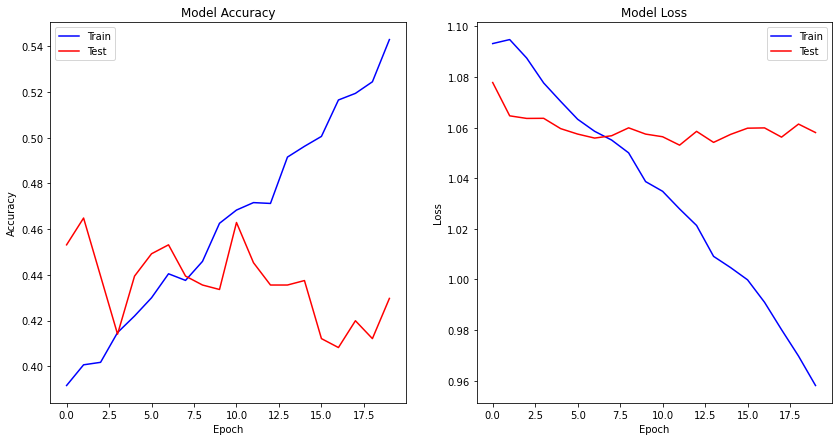

In [46]:

# Plot accuracy and loss to visualize model results

plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.plot(Xception_history.history['accuracy'], color='b')
plt.plot(Xception_history.history['val_accuracy'], color='r')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.subplot(1,2,2)
plt.plot(Xception_history.history['loss'], color='b')
plt.plot(Xception_history.history['val_loss'], color='r')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

plt.show()

The Xception model looks about the same as the Previous CNN model. It looks like I could have used more epochs to see where these curves are going to plateau. However, experimenting with more epochs on this model is much more costly that with the first CNN and nearly every model I evaluated had the same characteristic flaws as I mentioned above when evaluating the first CNN's performance with accuracy and loss. It does look like it will 2-3 take more iterations than the first CNN model to reach near the curves plateaus. This may be an indication of stability of the model and training process. This means there's a higher probability that working with this model to improve its performance will lead to a higher performing model overall.

In [51]:
# Save model weights and architecture
Xception_model.save("xception_predict_day_market.h5")

In [52]:
# Load saved model
trained_Xception_model = load_model("xception_predict_day_market.h5")

In [53]:
# Model summary
trained_Xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

Evaluation words

In [55]:
# Applys best weights to model
base_model_Xception = applications.Xception(
    weights='imagenet', # use pre-trained weights
    include_top=False # not including fully connected layers
)

x = base_model_Xception.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

predictions = Dense(3, activation='softmax')(x)
Xception_model = Model(inputs=base_model_Xception.input, outputs=predictions)

# Load weights
Xception_model.load_weights("xception_predict_day_market.h5")

In [56]:
Xception_model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=.0001, momentum=0.9), metrics=['accuracy'])

In [57]:
# Evaluation scores
scores = Xception_model.evaluate(validation_generator, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 1.058395266532898
Test accuracy: 0.428846150636673


In [58]:
# Confusion matrix
predictions = Xception_model.predict_generator(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
y_true = validation_generator.classes
cm = confusion_matrix(y_true=y_true, y_pred=predicted_classes)
cm

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([[ 27,   3, 127],
       [ 21,   5,  91],
       [ 35,  16, 195]])

In [59]:
# Classification report
class_labels = list(validation_generator.class_indices.keys()) 
report = classification_report(y_true, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

        gain       0.33      0.17      0.22       157
        loss       0.21      0.04      0.07       117
     neutral       0.47      0.79      0.59       246

    accuracy                           0.44       520
   macro avg       0.34      0.34      0.30       520
weighted avg       0.37      0.44      0.36       520



Evaluation words

# Conclusions and Recommendations

The goal of this project was to build a convolutional neural network to predict if the 8th day price movement would be a gain, neutral, or a loss, on average. Although there is some ability to predict the test set correctly, it' has only a slightly better chance of being correct than simply predicting the most likely outcome; which is loss, at 43.4%. The best performing simple CNN model scored: Test loss = 1.1721, Test accuracy = 0.04289. While the best performing model produced with the Xception pretrain scored: Test loss = 1.0584, Test accuracy = 0.04288. By this metric it is hard to choos one over the other beacause their performance is similarly poor. 

The quantitative metrics tells a similar story of performance as the plots do. However, when you compare the confusion matricies and the classification, it becomes clear that the Xception pretrained model does not score better F1 scores than the simple CNN. Well, except for the neutral category predictions. The precision and recall calculated from the confusion matricies are nearly all much less than 0.5. Only the recall score for the neutral class in the Xception model performed well at 0.79; which is the ratio of (True Positives) to the sum of (True Positives + False Negatives). There's a significant headspace for performance improvement across the board; and now we no what the models are bad or good at predicting and by how much.

The primary recommendation I would have for conducting further analysis on this topic would be to collect much more image data. Market activity image data can be collected from additional exchanges and market watching websites. Another additional feature to play with would be to investigate trying to overlay the image sets with more useful analysis metrics; The Bitstamp Tradeview had dozens of metrics to apply to the graph and I only added to the candlestick tickers was a trade volume metric, and four Hamming moving averages with different period lengths. Additionally, the CNN model could use more optimization than time allowed fore in this capstone. The model architecture could always use further optimization, as well as the hyperparameters.